<a href="https://colab.research.google.com/github/Karolis05/codeacademy/blob/main/MLP_model(COVID-19).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')
import plotly 
import plotly.express as px
import plotly.graph_objects as go
import pycaret as regression
from scipy import stats
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot

#matplotlib inline
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
import tensorflow as tf

# set the random seed for TensorFlow
tf.random.set_seed(1)

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Read data

In [ ]:
#data_world = pd.read_csv('worldometer_data.csv')  
#data_country = pd.read_csv('country_wise_latest.csv') 
data_days = pd.read_csv('day_wise.csv')
#data_complete = pd.read_csv('covid_19_clean_complete.csv')
#data_full_grouped = pd.read_csv('full_grouped.csv')

Split data into train and test

In [ ]:
# Read the CSV file 'day_wise.csv' into a DataFrame, parsing the 'Date' column as dates
data = pd.read_csv('day_wise.csv', parse_dates=['Date'])

# Split the data into training and test sets
train_size = 0.8  # 80% of the data will be used for training
train_idx = int(len(data) * train_size)

train = data.iloc[:train_idx]  # Select the first 'train_idx' rows for training
test = data.iloc[train_idx:]  # Select the remaining rows for testing

# Print the shapes of the training and test sets
print(f'Training set shape: {train.shape}')
print(f'Test set shape: {test.shape}')

Training set shape: (150, 12)
Test set shape: (38, 12)


In [ ]:
# Define the columns to delete from the test and train DataFrames
columns_to_delete = ['Confirmed', 'Deaths', 'Recovered', 'Active', 'New deaths', 'New recovered',
                     'Deaths / 100 Cases', 'Recovered / 100 Cases', 'Deaths / 100 Recovered', 'No. of countries']

# Drop the specified columns from the test DataFrame and assign the result to 'df_test'
df_test = test.drop(columns=columns_to_delete)

# Drop the specified columns from the train DataFrame and assign the result to 'df'
df = train.drop(columns=columns_to_delete)

In [ ]:
# Print the minimum and maximum dates from the 'Date' column in the train DataFrame
print('Min date from train set: %s' % df['Date'].min().date())
print('Max date from train set: %s' % df['Date'].max().date())

Min date from train set: 2020-01-22
Max date from train set: 2020-06-19


EDA

In [ ]:
# Group the data in the 'df' DataFrame by 'Date' and calculate the sum of 'New cases' for each date
daily_cases = df.groupby('Date', as_index=False)['New cases'].sum()



The graph illustrates the number of daily Covid-19 cases. The graph shows a trend. The data is relatively low until March 1st, and from the end of June, there is a significant sharp increase.

In [ ]:
# Create a scatter plot of daily cases 
daily_cases_sc = go.Scatter(x=daily_cases['Date'], y=daily_cases['New cases'])

# Define the layout of the plot
layout = go.Layout(title='Daily cases', xaxis=dict(title='Date'), yaxis=dict(title='New cases'))
fig = go.Figure(data=[daily_cases_sc], layout=layout)
iplot(fig)

I chose a 5-day window size for the moving average because the number of cases varies sharply each day. Therefore, a larger window would introduce more delay in the data. So using a 5-day window, helps to smoothing out the daily fluctuations in the data and obtaining a more stable trend.

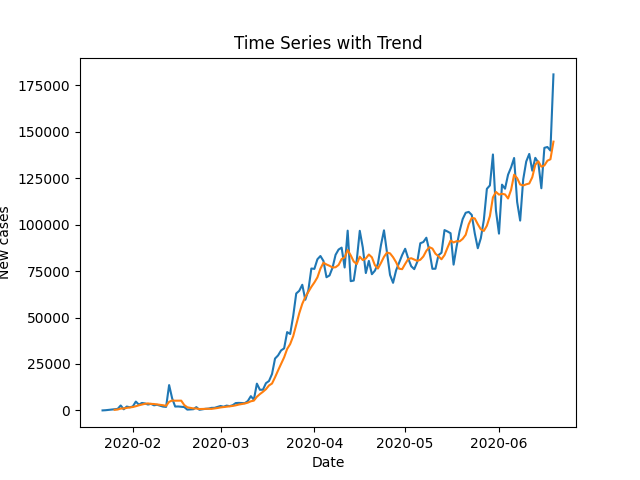

In [ ]:
# Define the window size for the moving average
window = 5

# Calculate the moving average and assign it to the 'trend' column in the daily_cases DataFrame
daily_cases['trend'] = daily_cases['New cases'].rolling(window).mean()


plt.figure()

# Plot the original daily cases data
plt.plot(daily_cases['Date'], daily_cases['New cases'], label='Original')

# Plot the trend (moving average) data
plt.plot(daily_cases['Date'], daily_cases['trend'], label='Trend')
plt.xlabel('Date')
plt.ylabel('New cases')
plt.title('Time Series with Trend')
plt.show()




The graphs clearly show a rising long-term trend, indicating seasonality. Looking at the residuals, it seems that departures from normality could indicate issues such as nonlinearity or heteroscedasticity in the model.

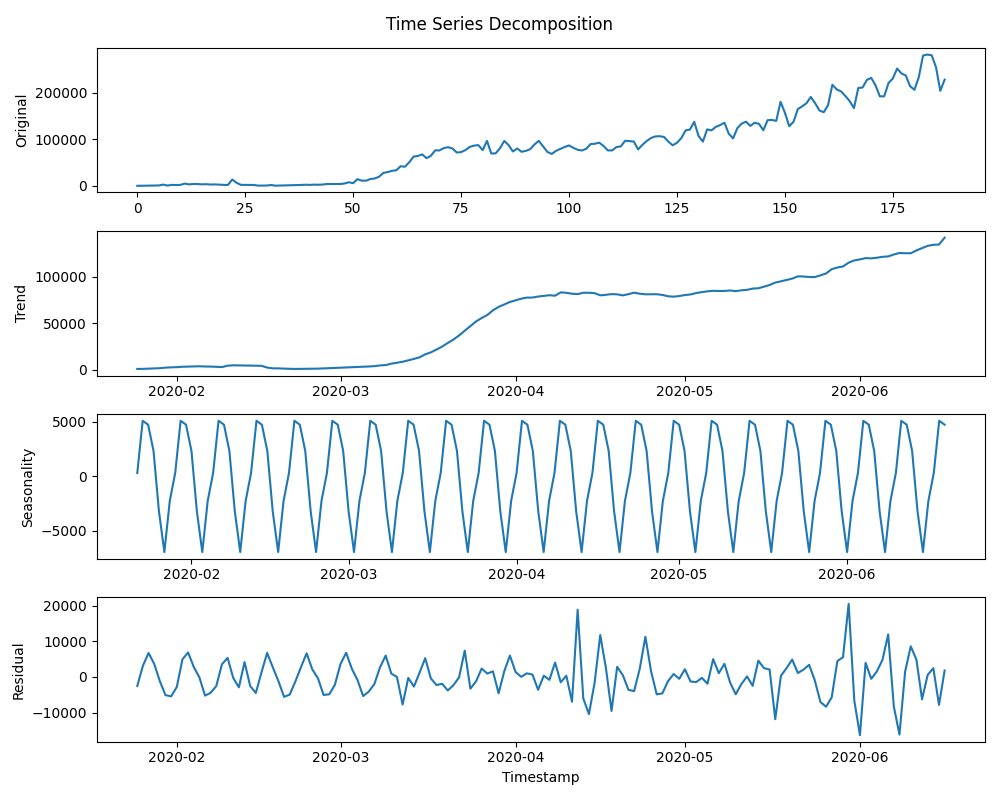

In [ ]:

# Set the 'Date' column as the index of the daily_cases DataFrame
daily_cases.set_index('Date', inplace=True)

# Perform seasonal decomposition on the 'New cases' column using the 'additive' model
decomposition = seasonal_decompose(daily_cases['New cases'], model='additive')


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

# Plot the original daily cases data in the first subplot
ax1.plot(data['New cases'])
ax1.set_ylabel('Original')

# Plot the trend component in the second subplot
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

# Plot the seasonal component in the third subplot
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonality')

# Plot the residual component in the fourth subplot
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residual')

plt.xlabel('Timestamp')
plt.suptitle('Time Series Decomposition')
plt.tight_layout()
plt.show()

We can confirm that indeed there is no stationarity in the data.
Function to check the stationarity of a time series using the ADF test.
    

In [ ]:

def check_stationarity(daily_cases):
    
    result = adfuller(daily_cases)  
    print('ADF Statistic:', result[0])  
    print('p-value:', result[1])  
    print('Critical Values:')  
    for key, value in result[4].items():
        print(f'{key}: {value}')

    if result[1] <= 0.05:
        print('The time series is stationary.')  #
    else:
        print('The time series is not stationary.')  

check_stationarity(daily_cases['New cases'])  

ADF Statistic: 0.2860133456352035
p-value: 0.9766936082721956
Critical Values:
1%: -3.47864788917503
5%: -2.882721765644168
10%: -2.578065326612056
The time series is not stationary.


For the forecasting model, I will use lagged data. The selection of significant lag values will be based on autocorrelation. Since the forecasting interval is 38 days, I will determine the number of significant lag values within that range.

To identify the important lag values for forecasting COVID-19 new cases, I will utilize the Partial Autocorrelation Function (PACF). PACF helps assess the direct influence of each lag on the current observation, making it a valuable tool for selecting relevant lag values in the forecasting process.

Based on the PACF analysis, the important lag values for the forecast are found to be 0, 1, 2, 5, 8, 9, 12, and 34.

Using the moving average of each lagged data in time series analysis provides the following benefits:

Identifying the overall direction or movement of the time series: By calculating the moving average, we can smoothen out data fluctuations and noise, allowing us to observe the underlying trend or pattern more clearly. This helps in understanding whether the time series is generally increasing, decreasing, or remaining relatively stable.

Reducing noise in the data: Time series data often contain random fluctuations or outliers that can obscure meaningful patterns. Applying the moving average helps mitigate the impact of these fluctuations, resulting in a smoother representation of the data. This facilitates the identification of underlying trends and enables more accurate predictions.

Additionally, along with the moving average of lagged data, incorporating trend and seasonality data as features further enhances the forecasting model. Trend captures long-term increasing or decreasing patterns, while seasonality accounts for recurring patterns within specific time periods. Including these features improves the accuracy of predictions by considering their influence on the time series.

In summary, by incorporating lagged data, selecting significant lag values using PACF, and utilizing moving average, trend and seasonality, the forecasting model can effectively capture the overall movement, reduce noise, and make accurate predictions for COVID-19 new cases



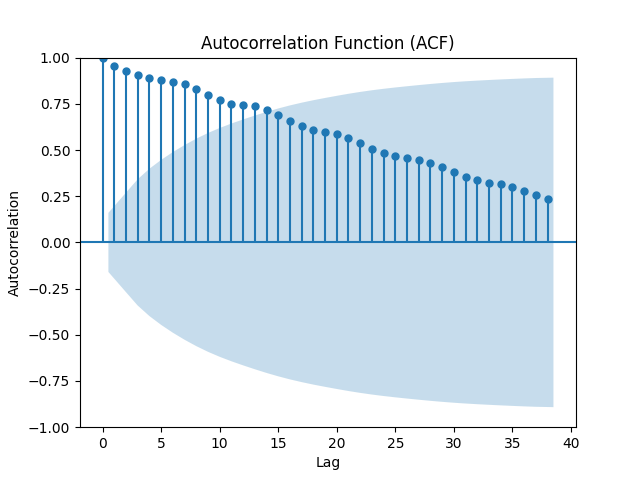

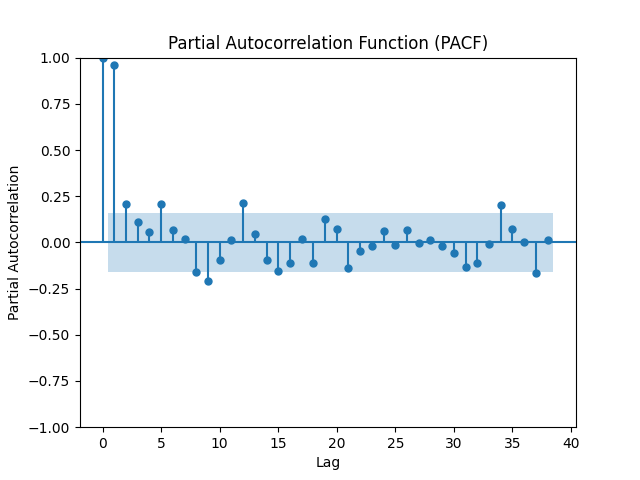

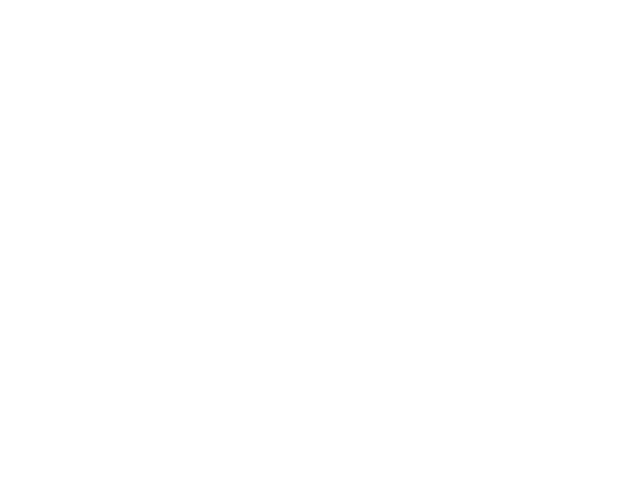

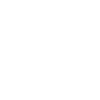

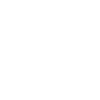

In [ ]:
Xdc = daily_cases
plt.figure()
plt.figure(figsize=(1, 1))
plot_acf(Xdc['New cases'], lags=38, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()
plt.figure(figsize=(1, 1))
plot_pacf(Xdc['New cases'], lags=38, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()
#plt.close()

In [ ]:
 Add meaningfull lags to dataset [train and test]

In [ ]:


def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in lags
        },
        axis=1)


lags = [0,1,2,5,9,12,34]
lags1 = [0,1,2,5,9,12,34]

# Create lagged columns for train data:
Xdc = make_lags(Xdc['New cases'], lags=lags)
Xdc = Xdc.fillna(0.0)

# Create lagged columns for test data:
Ydc = make_lags(df_test['New cases'], lags=lags)
Ydc = Ydc.fillna(0.0)

# Print the  train DataFrame to see the lagged values
Xdc = Xdc.rename(columns={'y_lag_0':'New cases'})
# Print the  test DataFrame to see the lagged values
Ydc = Ydc.rename(columns={'y_lag_0':'New cases'})
#column_data_type = ['moving_average', 'moving_average_lag_1',
     #  'moving_average_lag_2', 'moving_average_lag_5', 'moving_average_lag_8',
      # 'moving_average_lag_9', 'moving_average_lag_12',
      # 'moving_average_lag_34']
#Xdc[column_data_type] = Xdc[column_data_type].astype(np.int64)



In [ ]:
Add Moving average with lags

In [ ]:
window_size = 4
#Moving average for training data
Xdc['moving_average'] = Xdc['New cases'].rolling(window=window_size, min_periods=1).mean()
##Moving average for test data
Ydc['moving_average'] = Ydc['New cases'].rolling(window=window_size, min_periods=1).mean()
# Shift the moving average values to align with the lagged columns
for lag in [1, 2, 5, 8, 9, 12, 34]:
    Xdc[f'moving_average_lag_{lag}'] = Xdc['moving_average'].shift(lag)
for lag in [1, 2, 5, 8, 9, 12, 34]:
    Ydc[f'moving_average_lag_{lag}'] = Ydc['moving_average'].shift(lag)
column_data_type = ['New cases', 'y_lag_1', 'y_lag_2', 'y_lag_5', 'y_lag_8', 'y_lag_9',
       'y_lag_12', 'y_lag_34','moving_average', 'moving_average_lag_1',
       'moving_average_lag_2', 'moving_average_lag_5', 'moving_average_lag_8',
       'moving_average_lag_9', 'moving_average_lag_12',
       'moving_average_lag_34']

# It needs to to replace NaN values with 0 
# Train data
import pandas as pd
Xdc.fillna(0, inplace= True) 
#Xdc[column_data_type] = Xdc[column_data_type].astype(np.float64)
# Test data
Ydc.fillna(0, inplace= True) 
#Ydc[column_data_type] = Ydc[column_data_type].astype(np.float64)



In [ ]:
Add Trend and seasonality to training and test datasets

In [ ]:


# training data
X_train = Xdc.drop(['New cases'], axis=1)  # Exclude the target variable
y_train = Xdc['New cases']                 # target variable

# Test data
X_test = Ydc.drop(['New cases'], axis=1)  # Exclude the target variable
y_test = Ydc['New cases']                 # target variable



# Calculate seasonality for train data
result = seasonal_decompose(Xdc['New cases'], model='additive', period=7)  # Assuming a weekly seasonality with a period of 7
Xdc['seasonality'] = result.seasonal

# Calculate seasonality for test data
result_test = seasonal_decompose(Ydc['New cases'], model='additive', period=7)  # Assuming a weekly seasonality with a period of 7
Ydc['seasonality'] = result_test.seasonal

# Calculating Trend for Train data
lr_model = LinearRegression()
lr_model.fit(X_train[['y_lag_1',  'y_lag_2', 'y_lag_5']], y_train)    #, 'y_lag_2', 'y_lag_5', 'y_lag_8', 'y_lag_9', 'y_lag_12', 'y_lag_34'

# Calculating Trend for Test data 
lr_model_test = LinearRegression()
lr_model_test.fit(X_test[['y_lag_1', 'y_lag_2', 'y_lag_5']], y_test)    #, 'y_lag_2', 'y_lag_5', 'y_lag_8', 'y_lag_9', 'y_lag_12', 'y_lag_34'


# Obtain trend predictions for train data
trend = lr_model.predict(X_train[['y_lag_1', 'y_lag_2', 'y_lag_5']])

# Obtain trend predictions for test data
trend_test = lr_model_test.predict(X_test[[ 'y_lag_1','y_lag_2', 'y_lag_5']])


# Add trend column to train dataset
X_train['trend'] = lr_model.predict(X_train[['y_lag_1', 'y_lag_2', 'y_lag_5']])

# Add trend column to test dataset
X_test['trend'] = lr_model_test.predict(X_test[['y_lag_1', 'y_lag_2', 'y_lag_5']])

SPLITING DATA [TRAIIN VALIDATION]....[TEST]

In [ ]:

# Set the split date for dividing the data into training and validation sets
split_date = pd.to_datetime('2020-06-01')

train_data = X_train[X_train.index < split_date]
val_data = X_train[X_train.index >= split_date]

print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))


# Add features and target data
features = ['y_lag_2', 'y_lag_5',  'y_lag_9', 'y_lag_12',
       'y_lag_34', 'moving_average', 'moving_average_lag_1',
       'moving_average_lag_2', 'moving_average_lag_5', 'moving_average_lag_8',
       'moving_average_lag_9', 'moving_average_lag_12',
       'moving_average_lag_34', 'seasonality', 'trend']

y_train = train_data['y_lag_1']
x_train = train_data[features]
y_val = val_data['y_lag_1']
x_val = val_data[features]
X_test = X_test.drop(['y_lag_1'], axis=1)



Training set size: 131
Validation set size: 19


MLP model for Time Series Forecasting

In [ ]:
#Hyperparameters
epochs = 50
batch = 5
lr = 0.003
adam = optimizers.Adam(lr)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 128)               2048      
                                                                 
 dropout_78 (Dropout)        (None, 128)               0         
                                                                 
 dense_113 (Dense)           (None, 32)                4128      
                                                                 
 dropout_79 (Dropout)        (None, 32)                0         
                                                                 
 dense_114 (Dense)           (None, 64)                2112      
                                                                 
 dense_115 (Dense)           (None, 1)                 65        
                                                                 
Total params: 8,353
Trainable params: 8,353
Non-train

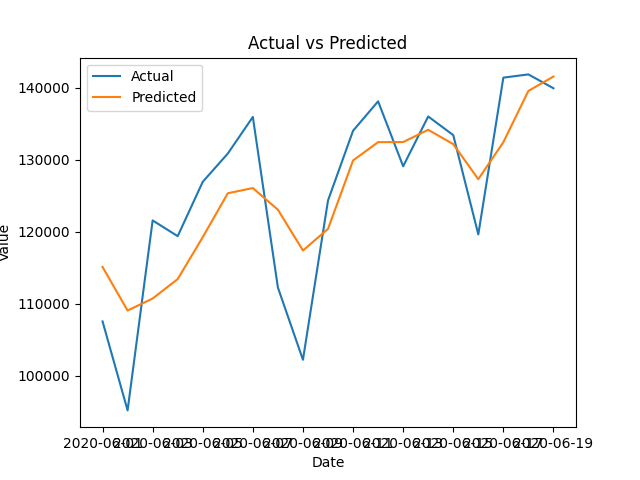

Text(0, 0.5, 'MAE')

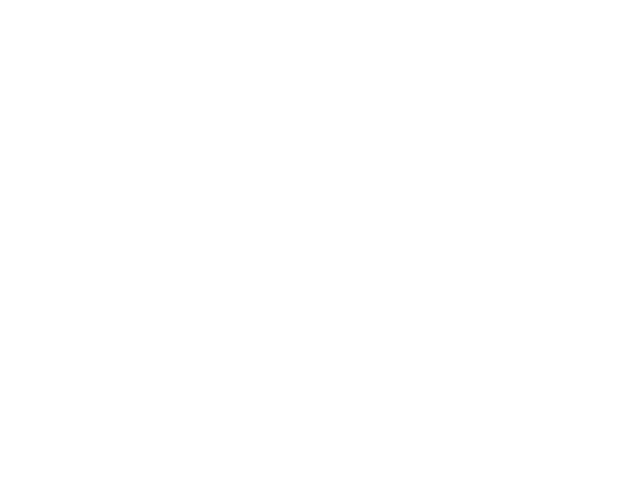

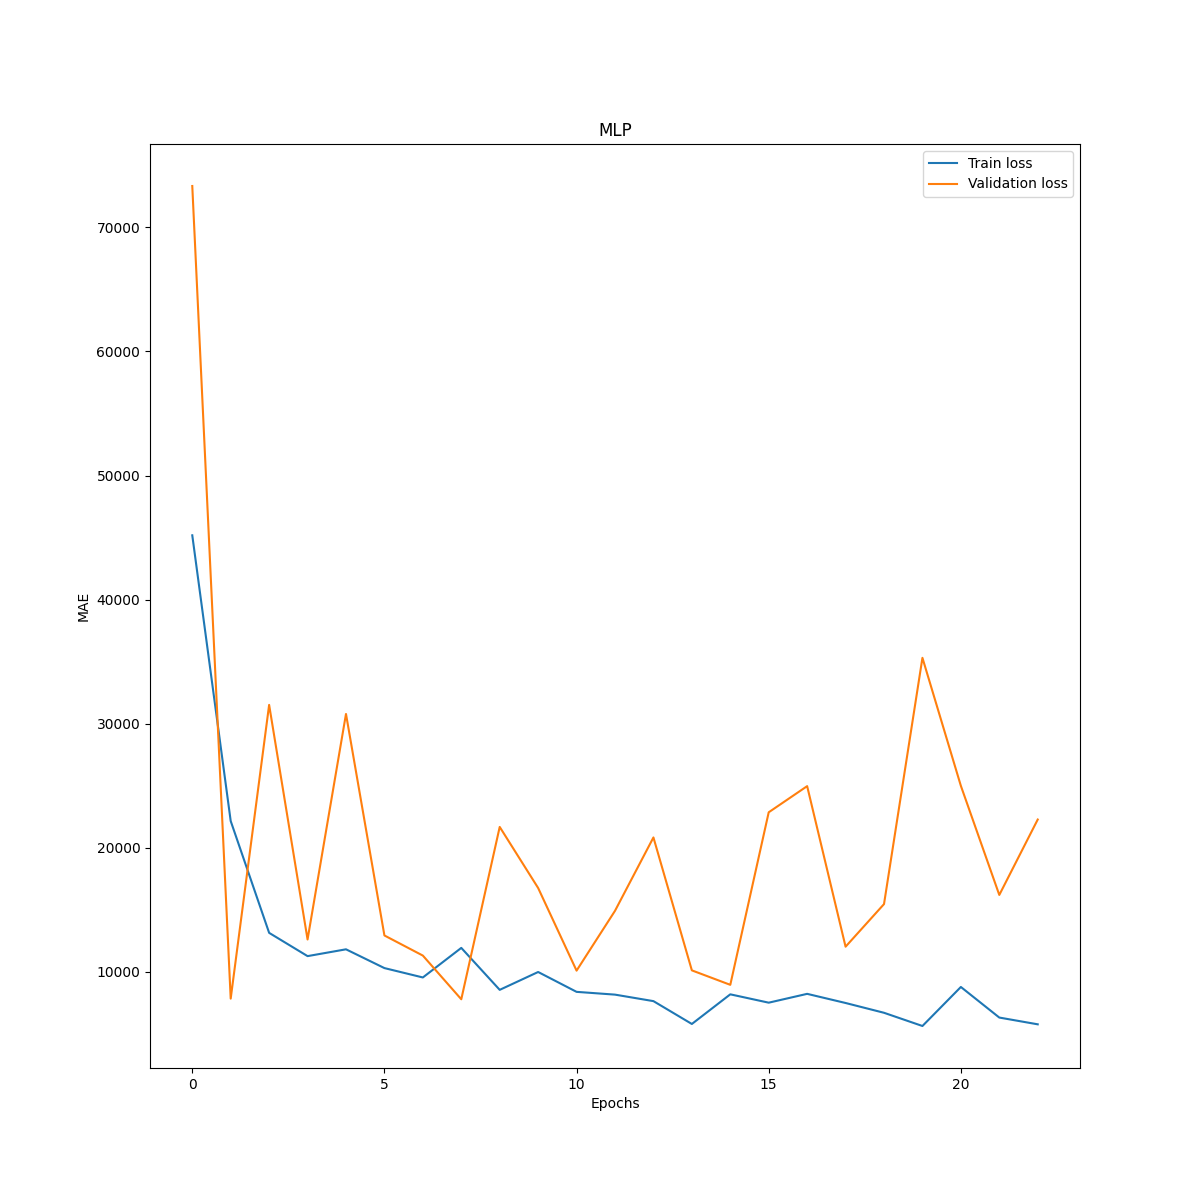

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

# Create the MLP model
model_mlp = Sequential()
model_mlp.add(Dense(128, activation='relu', input_dim=x_train.shape[1]))
model_mlp.add(Dropout(0.1))
model_mlp.add(Dense(32, activation='relu'))
model_mlp.add(Dropout(0.2))
model_mlp.add(Dense(64, activation='relu'))
#model_mlp.add(Dropout(0.1))
model_mlp.add(Dense(1))

# Compile the model
model_mlp.compile(loss='mae', optimizer='adam')
model_mlp.summary()

# Train the model
mlp_history = model_mlp.fit(x_train.values, y_train.values, validation_data=(x_val.values, y_val.values), epochs=epochs, verbose=2, callbacks=[early_stopping])


mse1 = mean_squared_error(y_val, y_pred)

# Plot Actual vs Predicted values
plt.figure()
plt.plot(y_val.index, y_val, label='Actual')
plt.plot(y_val.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

# Plot loss curves for training and validation
plt.figure()
fig, axe = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12, 12))
ax1 = axe
ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE')



In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model_mlp.predict(x_val)
# Evaluate the model's performance



1/1 [==============================] - 0s 36ms/step


Based on the results obtained, it can be concluded that the MLP (Multi-Layer Perceptron) model outperforms the baseline model in predicting the target variable, which is the number of daily COVID-19 new cases.

The MLP model demonstrates lower root mean squared error (RMSE) values for both the training and validation sets compared to the baseline model. The RMSE measures the average difference between the predicted values and the actual values. A lower RMSE indicates better performance and suggests that the MLP model is able to make more accurate predictions.

Furthermore, the MLP model also performs better on the test set when compared to the baseline model. The test set results show a lower RMSE for the MLP model, indicating that it is able to generalize well to unseen data and provide more accurate predictions.

Here are the RMSE values for the baseline and MLP models:

Baseline Test RMSE: 163,928.71
MLP Test RMSE: 30,086.47
Baseline Train RMSE: 40,989.86
Baseline Validation RMSE: 80,336.20
MLP Train RMSE: 5,757.85
MLP Validation RMSE: 8,506.73

Based on these results, the MLP model exhibits significantly lower RMSE values compared to the baseline model, suggesting that it provides improved accuracy in predicting the number of daily COVID-19 new cases.

Baseline and MLP model comparison on Train, Validation and Test data

In [ ]:
# MLP predictions on the training and validation sets
mlp_train_pred = model_mlp.predict(x_train.values)
mlp_valid_pred = model_mlp.predict(x_val.values)

# Calculate RMSE for MLP on the training and validation sets
train_rmse = np.sqrt(mean_squared_error(y_train.values, mlp_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_val.values, mlp_valid_pred))

print('Train RMSE:', train_rmse)
print('Validation RMSE:', valid_rmse)


# Baseline predictions using the mean of the training set
baseline_train_pred = np.full_like(y_train.values, np.mean(y_train.values))
baseline_valid_pred = np.full_like(y_val.values, np.mean(y_train.values))

# Calculate RMSE for the baseline on the training and validation sets
train_rmse_baseline = np.sqrt(mean_squared_error(y_train.values, baseline_train_pred))
valid_rmse_baseline = np.sqrt(mean_squared_error(y_val.values, baseline_valid_pred))

# Calculate RMSE for MLP on the training and validation sets
train_rmse_mlp = np.sqrt(mean_squared_error(y_train.values, mlp_train_pred))
valid_rmse_mlp = np.sqrt(mean_squared_error(y_val.values, mlp_valid_pred))


# Baseline predictions on the test set
baseline_test_pred = np.full_like(y_test.values, np.mean(y_train.values))
# MLP predictions on the test set
mlp_test_pred = model_mlp.predict(X_test.values)
# Calculate RMSE for the baseline on the test set
test_rmse_baseline = np.sqrt(mean_squared_error(y_test.values, baseline_test_pred))
# Calculate RMSE for MLP on the test set
test_rmse_mlp = np.sqrt(mean_squared_error(y_test.values, mlp_test_pred))

print('Baseline Test RMSE:', test_rmse_baseline)
print('MLP Test RMSE:', test_rmse_mlp)


print('Baseline Train RMSE:', train_rmse_baseline)
print('Baseline Validation RMSE:', valid_rmse_baseline)

print('MLP Train RMSE:', train_rmse_mlp)
print('MLP Validation RMSE:', valid_rmse_mlp)

1/1 [==============================] - 0s 15ms/step
Train RMSE: 5757.848219559393
Validation RMSE: 8506.728925730094
2/2 [==============================] - 0s 3ms/step
Baseline Test RMSE: 163928.71409492538
MLP Test RMSE: 30086.474825977006
Baseline Train RMSE: 40989.85560829652
Baseline Validation RMSE: 80336.19655110505
MLP Train RMSE: 5757.848219559393
MLP Validation RMSE: 8506.728925730094
